## Tesseract 

Tesseract is an open source engine created by HP and maintained by Google that uses Long Short-Term Memory neural networks in its latest versions for improved accuracy. It was used via PyTesseract is a Python wrapper that facilitates working with Tesseract within Python environments.

The Tesseract OCR engine has several stages to process an image:

- **Image Preprocessing**: it applies several steps like binarization, deskewing, and denoising to prepare the image for OCR which improves text detection, especially in complex or noisy images.

- **Text Segmentation**: next, Tesseract breaks down the image into lines, words, and then individual characters. This step is important to accurately interpret and reconstruct text.

- **Feature Extraction and Recognition**: Using pattern recognition and neural network techniques, Tesseract interprets each character and converts it into text. The latest versions use LSTM (Long Short-Term Memory) networks to improve accuracy, especially on irregular fonts and distorted characters.

- **Post-processing**: After text recognition, Tesseract applies language-specific rules and dictionaries to further refine the output, to help correct errors and improve overall readability. 

Source: https://tesseract-ocr.github.io/tessdoc


In [45]:
from PIL import Image
import pytesseract
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [46]:
pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"


Similar to the other solutions used during this project, this notebook follows the same workflow:
![image info](../data/workflow.png)

- Image Loading
- Image Preprocessing - different solutions required different preprocessing techniques.
- Text Extraction - here, saving raw (before any processing) and after transformations to deal with spaces and different symbols for multiplication.
- Contour Detection - to detect where the characters are located in the provided image
- Evaluate Expression - which outputs the result of the expression in the image

In [47]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    return image

In [48]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)

    # converts the image to grayscale and threshold it for contour detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # this defines a small kernel (2x2) for morphological operations to be used for denoising
    kernel = np.ones((2,2), np.uint8)
    denoised = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)   # this step applies a morphological "opening" operation, erosion followed by dilation. 
                                                                  # This helps reduce noise in the image by removing small white spots or noise
                                                                  
    
    return denoised


In [49]:
def predict_text_from_image(image):
    # to help the OCR to recognize the characters we expect to encounter in the expressions, 
    # a whitelist of characters is provided. This restricts the OCR to recognize only these characters.
    whitelist = "0123456789+-*/().Xx"
    custom_config = f'-c tessedit_char_whitelist={whitelist} --psm 7 --oem 3'
    # --psm 7 -> sets Page Segmentation Mode (PSM) to 7, which assumes a single line of text
    # --oem 3 -> sets the OCR Engine Mode to "3", which uses a combination of traditional and LSTM-based OCR models, which we found to work best for our case.
    
    text = pytesseract.image_to_string(image, config=custom_config)
    
    return text.strip()

Limiting the OCR to the characters in the whitelist means that more complex operations with variables, for instance, are not being considered for this case. 
This would be an interesting step for future work.

**draw_bounding_boxes()** draws the bounding boxes around the detected characters in the image and displays it with the extracted text. 
It uses OpenCV to read and modify the image and PyTesseract's image_to_boxes function which returns recognized characters and their bounding boxes¹.

¹ https://pypi.org/project/pytesseract/


In [50]:
def draw_bounding_boxes(image_path, predicted_text):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    boxes = pytesseract.image_to_boxes(image)
    
    for b in boxes.splitlines():
        b = b.split(' ')
        image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 1)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"OCR Result with Bounding Boxes\nExtracted Text: {predicted_text}")
    plt.axis('off')
    plt.show()

With the text extracted, it is now possible to calculate the result of the expression found in the image.

Here we replace the different characters used in handwriting for multiplication ("x" and "X") as well as removing blank spaces and the "=" sign contain in some of the images.

The following set of regular expressions ensures that the expression follows the proper format when it comes to multiplication, for cases of implied multiplications.

re.match() is used to ensure that the equation only contains valid characters (digits, +, -, *, /, (, ), and .)

In [51]:
def evaluate_equation(equation):
    equation = equation.replace("x", "*").replace("X", "*")
    equation = equation.replace(" ", "").replace("=", "")

    equation = re.sub(r'(\d)(\()', r'\1*(', equation)  # digit followed by '('
    equation = re.sub(r'(\))(\d)', r')*\2', equation)  # ')' followed by digit
    equation = re.sub(r'(\))(\()', r')*(', equation)   # ')' followed by '('

    if not re.match(r'^[\d\.\+\-\*/\(\)]+$', equation):
        return "Invalid Equation"
    
    try:
        result = eval(equation, {"__builtins__": None}, {})
        return result
    except (SyntaxError, ZeroDivisionError, NameError, TypeError) as e:
        return f"Error evaluating equation: {e}"

To check how the extraction went when compared to the ground truth, this function was provided.
We use the SequenceMatcher class difflib module, which measures the similarity between the two strings.

- CER, Character Error Rate, measure the number of wrongly predicted characters.
- The accuracy is defined as the ratio of matching characters to the total number of characters in the ground truth, represented in percentage.

In [52]:
def calculate_accuracy(predicted_text, ground_truth_text):
    if not predicted_text or not ground_truth_text:
        return 0.0

    ground_truth_text_cleaned = ground_truth_text.replace(" ", "")
    
    matcher = SequenceMatcher(None, predicted_text, ground_truth_text_cleaned)
    match_ratio = matcher.ratio()
    accuracy_percentage = match_ratio * 100
    
    return accuracy_percentage

In [53]:
def main(image_path, ground_truth):

    preprocessed_image = preprocess_image(image_path)
    
    predicted_text = predict_text_from_image(preprocessed_image)
    print("Extracted Text:", predicted_text)
    
    result = evaluate_equation(predicted_text)
    print("Calculated Result:", result)

    accuracy = calculate_accuracy(predicted_text, ground_truth)
    print(f"Accuracy: {accuracy:.2f}%")
    
    draw_bounding_boxes(image_path, predicted_text)



Extracted Text: 262+15
Calculated Result: 277
Accuracy: 76.92%


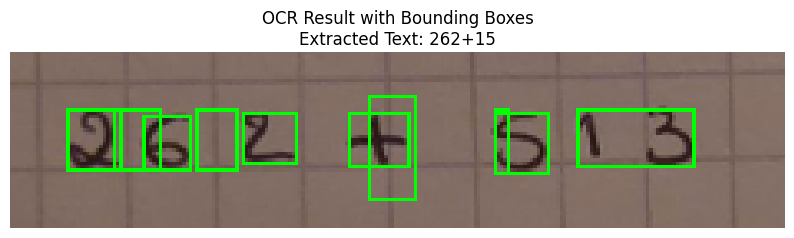

In [54]:
image_path = "../data/img_six.png"
ground_truth = "262+513"
main(image_path, ground_truth)

Extracted Text: 5x*42
Calculated Result: 227373675443232059478759765625
Accuracy: 16.67%


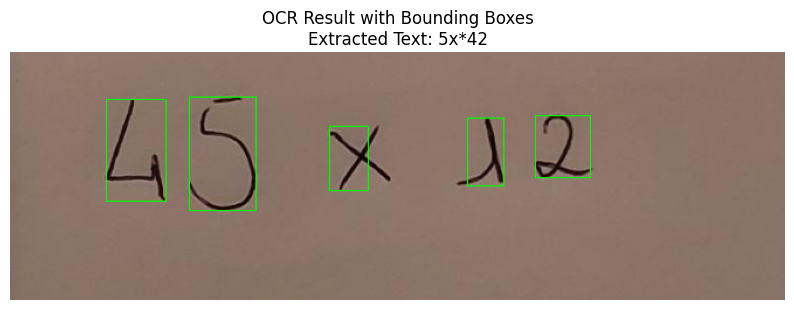

In [55]:
image_path = "../data/img_sixteen.png"
ground_truth = "262+513"
main(image_path, ground_truth)

In [56]:
image_path = "C:/Users/joana/OneDrive/Desktop/HSLU/3rd_semester/CV/c_vision_ocr/data/img_nine.png"
ground_truth = "90/5"
main(image_path, ground_truth)




error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Extracted Text: 3*
Calculated Result: Error evaluating equation: invalid syntax (<string>, line 1)
Accuracy: 28.57%


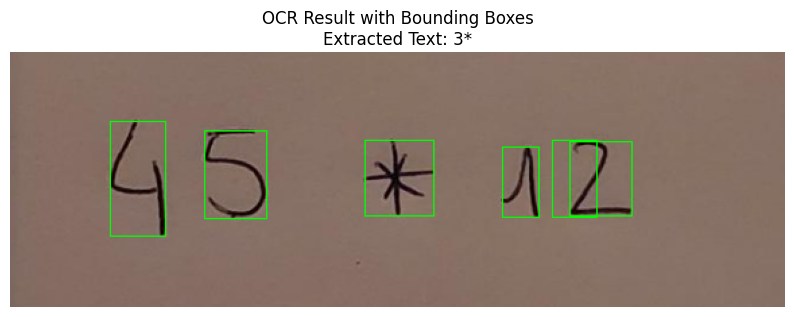

In [263]:
image_path = "C:/Users/joana/OneDrive/Desktop/HSLU/3rd_semester/CV/c_vision_ocr/data/img_seventeen.png"
ground_truth = "45*12"
main(image_path, ground_truth)

Extracted Text: 5x*42
Calculated Result: 227373675443232059478759765625
Accuracy: 60.00%


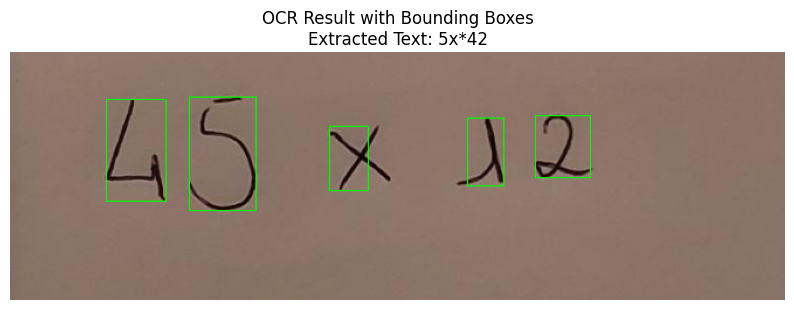

In [264]:
image_path = "C:/Users/joana/OneDrive/Desktop/HSLU/3rd_semester/CV/c_vision_ocr/data/img_sixteen.png"
ground_truth = "45x12"
main(image_path, ground_truth)

Extracted Text: x2
Calculated Result: Error evaluating equation: invalid syntax (<string>, line 1)
Accuracy: 50.00%


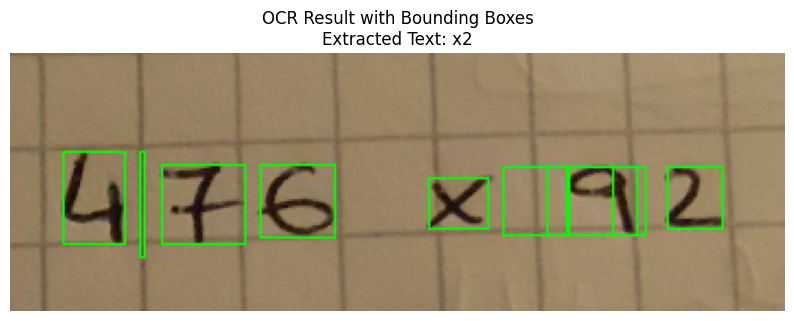

In [265]:
image_path = "C:/Users/joana/OneDrive/Desktop/HSLU/3rd_semester/CV/c_vision_ocr/data/img_ten.png"
ground_truth = "476x92"
main(image_path, ground_truth)

Extracted Text: 4+4
Calculated Result: 8
Accuracy: 57.14%


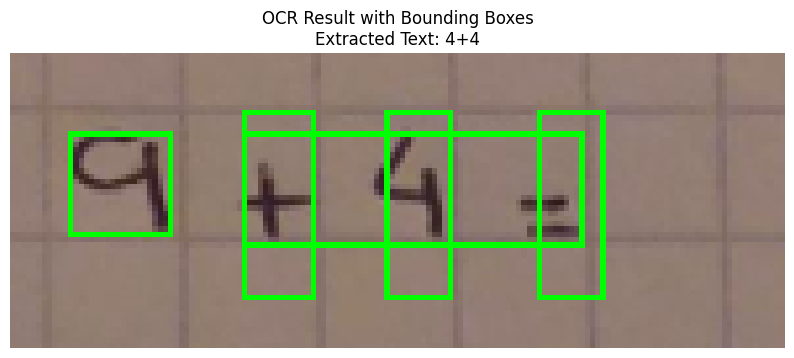

In [266]:
image_path = "C:/Users/joana/OneDrive/Desktop/HSLU/3rd_semester/CV/c_vision_ocr/data/img_four.png"
ground_truth = "9+4="
main(image_path, ground_truth)

Extracted Text: 3( 44) +(6/3)
Calculated Result: 134.0
Accuracy: 80.00%


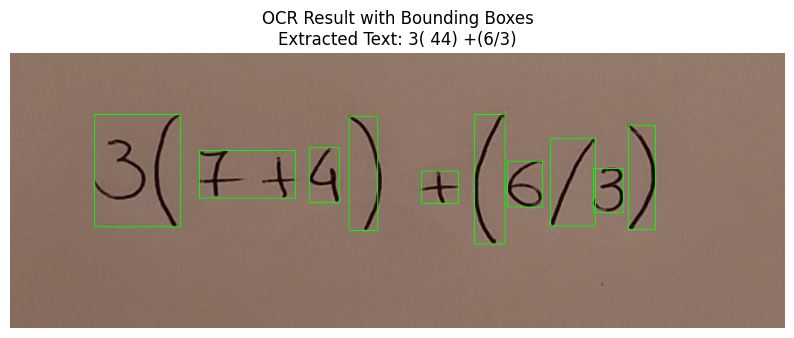

In [267]:
image_path = "C:/Users/joana/OneDrive/Desktop/HSLU/3rd_semester/CV/c_vision_ocr/data/img_twenty.png"
ground_truth = "3(7+4)+(6/3)"
main(image_path, ground_truth)